In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow as tf 
from tensorflow.keras import models, layers

from sklearn.model_selection import train_test_split 

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_train = x_train.astype(np.float32)/255. 

x_test = np.expand_dims(x_test, -1)
x_test = x_test.astype(np.float32)/255. 

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, shuffle = True, random_state = 1000)

print("Training Input shape: ", x_train.shape)
print("Validation Input shape: ", x_val.shape)
print("Test Input shape: ", x_test.shape)

Training Input shape:  (54000, 28, 28, 1)
Validation Input shape:  (6000, 28, 28, 1)
Test Input shape:  (10000, 28, 28, 1)


In [3]:
train_gen = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_gen = train_gen.batch(batch_size = 32).shuffle(buffer_size = 1000)

val_gen = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_gen = val_gen.batch(batch_size = 32).shuffle(buffer_size = 1000)

test_gen = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_gen = test_gen.batch(batch_size = 32).shuffle(buffer_size = 1000)

In [4]:
def sequentialModel(input_shape = (28, 28, 1)):

    model = models.Sequential([
        layers.Conv2D(filters = 32, kernel_size = (3, 3), input_shape = input_shape),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPool2D(2, 2),

        layers.Conv2D(filters = 64, kernel_size = (3, 3)),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPool2D(2, 2),

        layers.Flatten(),
        layers.Dense(10, activation = 'softmax')
    ])

    return model 

In [5]:
seqModel = sequentialModel()
seqModel.summary()

seqModel.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

seqHist = seqModel.fit(train_gen, validation_data = val_gen, epochs = 10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 64)        0

In [6]:
seqModel.evaluate(test_gen)

313/313 [==============================] - 1s 2ms/step - loss: 0.0445 - accuracy: 0.9861


[0.04450399428606033, 0.9861000180244446]

In [7]:
seqModel.save('SequentialModel.h5')

In [8]:
def functionalModel(input_shape = (28, 28, 1)):

    inp = layers.Input(shape = input_shape)
    
    mainBranch = layers.Conv2D(32, (3, 3), padding="same")(inp)
    mainBranch = layers.BatchNormalization()(mainBranch)
    mainBranch = layers.Activation("relu")(mainBranch)
    mainBranch = layers.MaxPool2D(2, 2)(mainBranch)
    
    branch1 = layers.Conv2D(32, (3, 3), padding="same")(mainBranch)
    branch1 = layers.BatchNormalization()(branch1)
    branch1 = layers.Conv2D(32, (3, 3), padding="same")(branch1)
    branch1 = layers.BatchNormalization()(branch1)

    mainBranch = layers.Add()([mainBranch, branch1])
    mainBranch = layers.Activation("relu")(mainBranch)
    mainBranch = layers.Conv2D(64, (3, 3), padding="same")(mainBranch)
    mainBranch = layers.MaxPool2D(2, 2)(mainBranch)

    flat = layers.Flatten()(mainBranch)
    dense = layers.Dense(10, activation = "softmax")(flat)

    model = models.Model(inputs = inp, outputs = dense)
    return model

In [9]:
funcModel = functionalModel()
funcModel.summary()

funcModel.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

funcHist = funcModel.fit(train_gen, validation_data = val_gen, epochs = 10)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 28, 28, 32)   128         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 28, 28, 32)   0           batch_normalization_2[0][0]      
______________________________________________________________________________________________

In [10]:
funcModel.evaluate(test_gen)

313/313 [==============================] - 1s 2ms/step - loss: 0.0402 - accuracy: 0.9883


[0.04021783918142319, 0.9883000254631042]

In [11]:
funcModel.save("FunctionalModel.h5")

/home/harish/anaconda3/envs/machine_learning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [12]:
class convBlock(layers.Layer):
    
    def __init__(self, numKernels, kernelSize, strides, padding="same"):
        super(convBlock, self).__init__() 

        self.conv = layers.Conv2D(numKernels, kernelSize, strides = strides, padding = padding)

        self.bnorm = layers.BatchNormalization()
        self.act = layers.Activation("relu") 

    def call(self, inTensor, training = False):

        x = self.conv(inTensor)
        x = self.bnorm(x, training = training)
        x = self.act(x)

        return x

In [13]:
class inceptionBlock(layers.Layer):

    def __init__(self, kernelSize_1, kernelSize_2, kernelSize_3):
        super(inceptionBlock, self).__init__() 

        self.conv_1 = convBlock(
            numKernels = kernelSize_1, 
            kernelSize = (1, 1), 
            strides = 1
        )

        self.conv_2 = convBlock(
            numKernels = kernelSize_2, 
            kernelSize = (2, 2),
            strides = 1
        )

        self.conv_3 = convBlock(
            numKernels = kernelSize_3,
            kernelSize = (3, 3),
            strides = 1
        )

        self.concat = layers.Concatenate() 

    def call(self, inTensor, training = False):
        
        x_1 = self.conv_1(inTensor, training = training)
        x_2 = self.conv_2(inTensor, training = training)
        x_3 = self.conv_3(inTensor, training = training)
        x = self.concat([x_1, x_2, x_3])

        return x

In [14]:
class downSampleBlock(layers.Layer):

    def __init__(self, numKernels):
        super(downSampleBlock, self).__init__() 

        self.conv_3 = convBlock(
            numKernels = numKernels,
            kernelSize = (3, 3),
            strides = 2,
            padding = "valid"
        )

        self.maxPool = layers.MaxPool2D(pool_size = (3, 3), strides = 2)

        self.concat = layers.Concatenate() 

    def call(self, inTensor, training = False):

        conv = self.conv_3(inTensor, training = training)
        pool = self.maxPool(inTensor)

        cat = self.concat([conv, pool])
        return cat

In [15]:
class InceptionModel(tf.keras.Model):

    def __init__(self, nClasses = 10):
        super(InceptionModel, self).__init__() 

        self.conv = convBlock(96, (3, 3), 1)
        
        self.incept_1 = inceptionBlock(32, 32, 32)
        self.incept_2 = inceptionBlock(32, 40, 48)
        self.down_1 = downSampleBlock(80)

        self.incept_3 = inceptionBlock(112, 80, 48)
        self.incept_4 = inceptionBlock(96, 80, 64)
        self.incept_5 = inceptionBlock(80, 80, 80)
        self.down_2 = downSampleBlock(96)

        self.pool = layers.GlobalAveragePooling2D()

        self.flatten = layers.Flatten() 
        self.dense = layers.Dense(nClasses, activation = "softmax") 

    def call(self, inTensor, training = False):

        x = self.conv(inTensor, training = training)

        x = self.incept_1(x)
        x = self.incept_2(x)
        x = self.down_1(x)

        x = self.incept_3(x)
        x = self.incept_4(x)
        x = self.incept_5(x)
        x = self.down_2(x) 

        x = self.flatten(self.pool(x))
        x = self.dense(x)

        return x

    def build_graph(self, inShape = (28, 28, 1)):
        inp = layers.Input(shape = inShape)
        return models.Model(inputs = [inp], outputs = self.call(inp))

In [16]:
conv = convBlock(96, (3, 3), 1)
inception = inceptionBlock(96, 80, 64)
downSample = downSampleBlock(96)

In [17]:
from tensorflow.keras.utils import plot_model 

def plot_layer(layer, to_file, inShape = (28, 28, 1)):

    x = layers.Input(shape = inShape)
    model = models.Model(inputs = [x], outputs = layer.call(x))
    plot_model(model, to_file=to_file, show_shapes=True, expand_nested=True)

In [18]:
plot_layer(conv, "subClassedConvBlock.png")
plot_layer(inception, "subClassedInceptionBlock.png")
plot_layer(downSample, "subClassedDownSampleBlock.png")


In [19]:
subClassModel = InceptionModel().build_graph()

subClassModel.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

subClassModel.fit(train_gen, validation_data = val_gen, epochs = 10)

Epoch 1/10
1688/1688 [==============================] - 87s 50ms/step - loss: 0.3454 - accuracy: 0.9295 - val_loss: 0.1046 - val_accuracy: 0.9743
Epoch 2/10
1688/1688 [==============================] - 84s 50ms/step - loss: 0.0748 - accuracy: 0.9830 - val_loss: 0.0918 - val_accuracy: 0.9725
Epoch 3/10
1688/1688 [==============================] - 84s 50ms/step - loss: 0.0481 - accuracy: 0.9886 - val_loss: 0.1092 - val_accuracy: 0.9677
Epoch 4/10
1688/1688 [==============================] - 84s 50ms/step - loss: 0.0354 - accuracy: 0.9914 - val_loss: 0.0489 - val_accuracy: 0.9845
Epoch 5/10
1688/1688 [==============================] - 84s 50ms/step - loss: 0.0274 - accuracy: 0.9938 - val_loss: 0.0545 - val_accuracy: 0.9833
Epoch 6/10
1688/1688 [==============================] - 85s 50ms/step - loss: 0.0211 - accuracy: 0.9955 - val_loss: 0.0431 - val_accuracy: 0.9880
Epoch 7/10
1688/1688 [==============================] - 85s 50ms/step - loss: 0.0166 - accuracy: 0.9965 - val_loss: 0.0438 -

In [20]:
subClassModel.evaluate(test_gen)


313/313 [==============================] - 5s 16ms/step - loss: 0.0378 - accuracy: 0.9885


[0.03775735944509506, 0.9884999990463257]

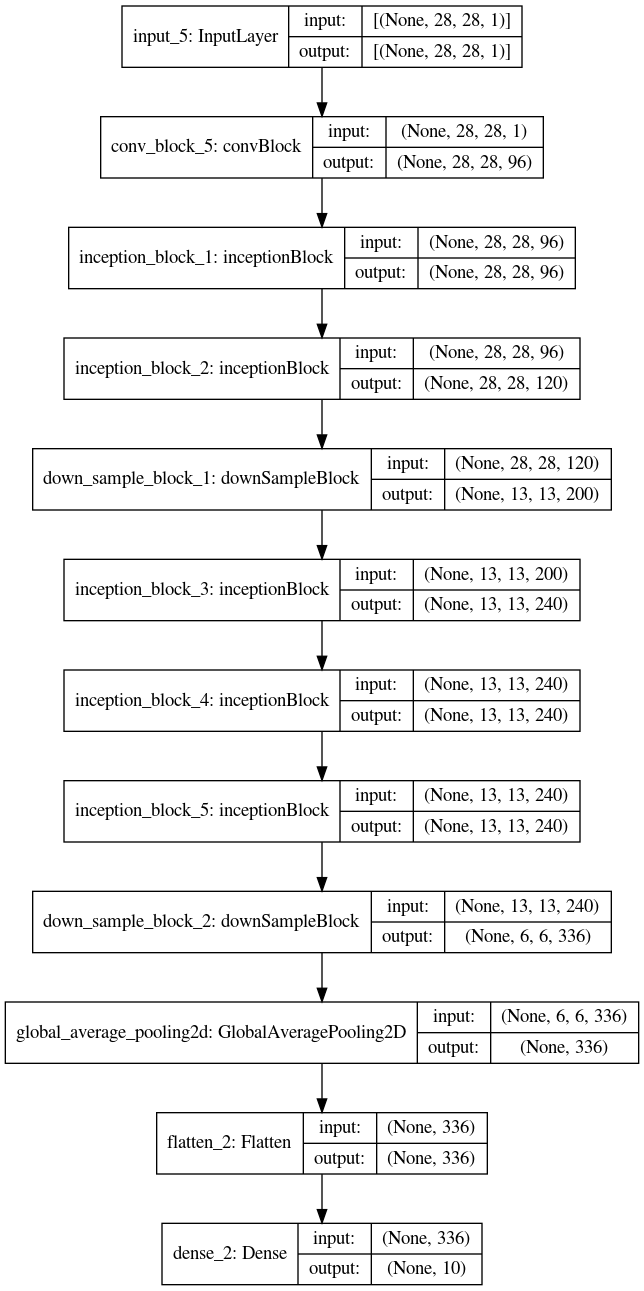

In [21]:
plot_model(subClassModel, to_file="subClassedModel.png", show_shapes=True, expand_nested = True)

In [29]:
@tf.function
def customTrainingStep(train_data):

    x, y_true = train_data 

    with tf.GradientTape() as tape:
        y_pred = inceptModel(x)
        loss = lossFunc(y_true, y_pred)
    
    gradient = tape.gradient(loss, inceptModel.trainable_weights)
    optim.apply_gradients(zip(gradient, inceptModel.trainable_weights))
    trainAccMetric.update_state(y_true, y_pred)
    
    return loss 

@tf.function
def customEvaluationStep(val_data):

    x_val, y_val = val_data 
    y_pred = inceptModel(x_val)
    valAccMetric.update_state(y_val, y_pred)

    return lossFunc(y_val, y_pred)

In [30]:
optim = tf.keras.optimizers.Adam(learning_rate = 0.00005)
lossFunc = tf.keras.losses.SparseCategoricalCrossentropy()
trainAccMetric = tf.keras.metrics.SparseCategoricalAccuracy()
valAccMetric = tf.keras.metrics.SparseCategoricalAccuracy()
inceptModel = InceptionModel()

epochs = 10

for epoch in range(epochs):
    print("Epoch {}/{}".format(epoch + 1, epochs))
    for batch_num, batch in enumerate(train_gen):
        loss = customTrainingStep(batch)

        if batch_num%200 == 199:
            print("Batch %d: Loss = %.3f Accuracy = %.3f" %(batch_num + 1, loss, trainAccMetric.result()))

    print("Metrics over epoch %d:" %(epoch+1))
    for batch_num, batch in enumerate(val_gen):
        val_loss = customEvaluationStep(batch)
    print("Loss: %.3f  Accuracy: %.3f\nVal Loss: %.3f  Val Accuracy: %.3f\n" %(loss, trainAccMetric.result(), val_loss, valAccMetric.result()))

    trainAccMetric.reset_states()
    valAccMetric.reset_states() 

Epoch 1/10
Batch 200: Loss = 1.572 Accuracy = 0.274
Batch 400: Loss = 0.735 Accuracy = 0.475
Batch 600: Loss = 0.380 Accuracy = 0.590
Batch 800: Loss = 0.245 Accuracy = 0.659
Batch 1000: Loss = 0.153 Accuracy = 0.706
Batch 1200: Loss = 0.189 Accuracy = 0.740
Batch 1400: Loss = 0.149 Accuracy = 0.766
Batch 1600: Loss = 0.173 Accuracy = 0.785
Metrics over epoch 1:
Loss: 0.130  Accuracy: 0.793
Val Loss: 0.124  Val Accuracy: 0.928

Epoch 2/10
Batch 200: Loss = 0.838 Accuracy = 0.933
Batch 400: Loss = 0.155 Accuracy = 0.932
Batch 600: Loss = 0.060 Accuracy = 0.935
Batch 800: Loss = 0.140 Accuracy = 0.937
Batch 1000: Loss = 0.081 Accuracy = 0.939
Batch 1200: Loss = 0.247 Accuracy = 0.941
Batch 1400: Loss = 0.201 Accuracy = 0.943
Batch 1600: Loss = 0.109 Accuracy = 0.945
Metrics over epoch 2:
Loss: 0.190  Accuracy: 0.944
Val Loss: 0.097  Val Accuracy: 0.956

Epoch 3/10
Batch 200: Loss = 0.148 Accuracy = 0.950
Batch 400: Loss = 0.189 Accuracy = 0.951
Batch 600: Loss = 0.116 Accuracy = 0.952
Ba